## Importing libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

## Defining the Objective function

In [42]:
def obj_fun(x):
     return 2*x[0]**2 + 3*x[1]**2 - 3*x[0]*x[1] + 2*x[0] -4*x[1]


def der_fun(x):
    return np.array([4*x[0] - 3*x[1] + 2, 
                     6*x[1] - 3*x[0] -4])


def hes_fun(x):
    return np.array([[4, -3], 
                     [-3, 6]])



### Visualizing the function

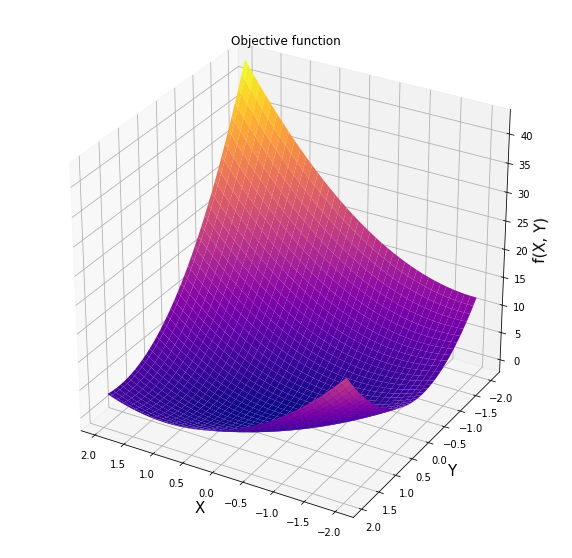

In [44]:
fig = plt.figure(figsize = (10, 10))
ax = fig.gca(projection = "3d")
X = np.arange(-2, 2, 0.05)
Y = np.arange(-2, 2, 0.05)
xmesh, ymesh = np.meshgrid(X, Y)
ax.plot_surface(xmesh, ymesh, obj_fun([xmesh, ymesh]), cmap = cm.plasma)
ax.view_init(elev = 30, azim = 120)
plt.xlabel('X', fontsize = 15)
plt.ylabel('Y', fontsize = 15)
ax.set_zlabel('f(X, Y)', fontsize = 15)
plt.title("Objective function")
plt.show()

## Backtracking Line Search

In [4]:
def bls(func, der_func, x, p, rho, alpha_bar = 1, c = 0.402):
    alpha = alpha_bar
    while(func(x + alpha*p) > func(x) + c*alpha*np.matmul(der_func(x).T, p)):
        alpha = rho*alpha
    return alpha

## Davidon-Fletcher-Powell function

In [5]:
def dfp(x_init, f, grad_f, precision = 1e-2, iterations = 100, rho=0.702):
    x1 = x_init
    y1 = x1
    D1 = np.identity(2, dtype = float)
    d1 = -np.matmul(D1, grad_f(y1))
    k = 1
    j = 1
    col_x1 = [x1[0]]
    col_x2 = [x1[1]]
    col_y1 = [y1[0]]
    col_y2 = [y1[1]]    
    direct = [d1]
    Hess = [D1]
    while np.linalg.norm(grad_f(y1)) > precision:
        alpha = bls(f, grad_f, y1, d1, rho, alpha_bar = 1)
#        print(d1)
        y2 = y1 + alpha*d1
        if j < 2: 
            p = alpha*d1
            q = grad_f(y2)-grad_f(y1)
            r1 = np.outer(p, p.T)/np.matmul(p.T, q)
            r2 = np.outer(np.matmul(D1, q), np.matmul(q.T, D1))/np.matmul(q.T, np.matmul(D1, q))
            D1 = D1 + r1 - r2
            j = j+1
            y1 = y2
            d1 = -np.matmul(D1, grad_f(y2))
            x1 = 'NULL'
        else:
            y1 = y2
            x1 = y2
            D1 = np.identity(2, dtype = float)
            d1 = -np.matmul(D1, grad_f(y1))
            j = 1
            k = k+1
        col_x1.append(x1[0])
        col_x2.append(x1[1])
        col_y1.append(y1[0])
        col_y2.append(y1[1])
        direct.append(d1)
        Hess.append(D1)
        
    df = pd.DataFrame({'X1': col_x1, 'X2': col_x2, 'Y1': col_y1, 'Y2': col_y2, 'Directions': direct, 'D': Hess})
    return df

In [6]:
x_init = np.array([0.0, 0.0])
DFP = dfp(x_init, obj_fun, der_fun)
DFP

,X1,X2,Y1,Y2,Directions,D
0,0,0,0.000000,0.000000,"[-2.0, 4.0]","[[1.0, 0.0], [0.0, 1.0]]"
1,N,U,-0.239361,0.478721,"[0.4508990635339303, 0.32897110370136995]","[[0.7173076923076922, 0.41153846153846146], [0..."
2,-0.0171557,0.640839,-0.017156,0.640839,"[-0.00885860110306158, 0.10349590165459244]","[[1.0, 0.0], [0.0, 1.0]]"
3,N,U,-0.018666,0.658484,"[0.03626748089654302, 0.017585432875661566]","[[0.7791058086976662, 0.4025184701081798], [0...."
4,-0.000793237,0.66715,-0.000793,0.667150,"[0.004623322800861196, -0.005280462049949364]","[[1.0, 0.0], [0.0, 1.0]]"


## Contour Plot - DFP

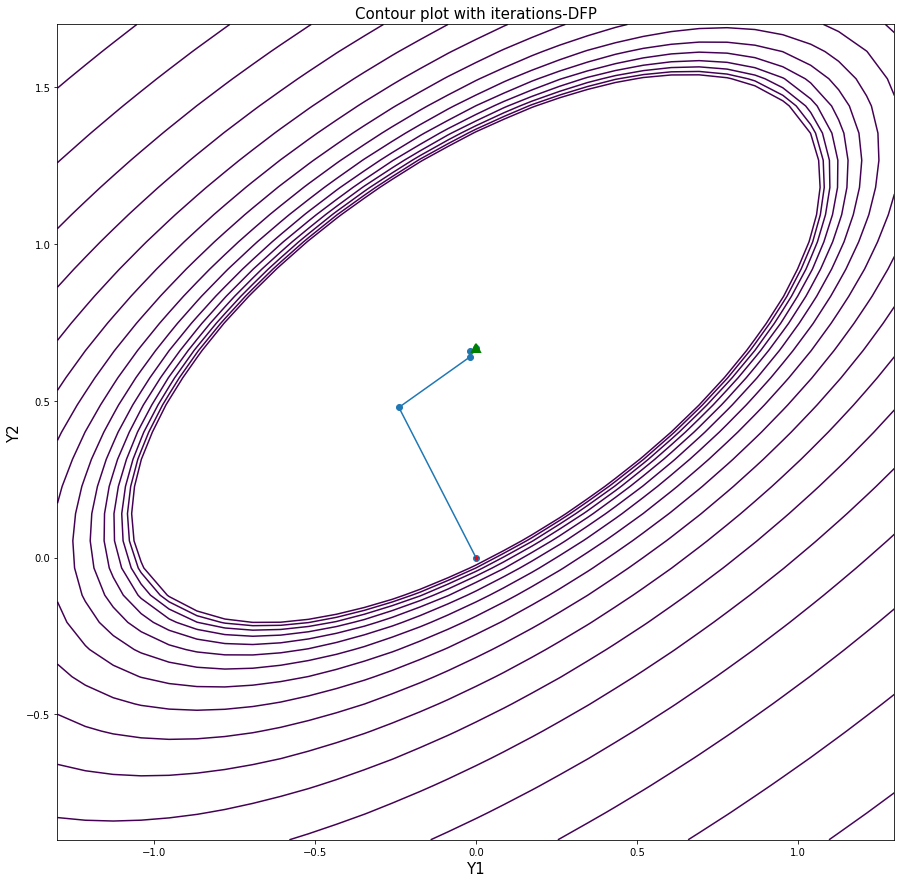

In [7]:
fig = plt.figure(figsize=(15, 15))
X, Y = np.meshgrid(np.linspace(-1.3, 1.3, 31), np.linspace(-0.9, 1.7, 31))
Z = obj_fun([X, Y])
plt.plot(np.array(DFP['Y1']), np.array(DFP['Y2']), marker = 'o')
plt.plot([0], [0], 'x', mew=1, markersize=5, color='red', marker = '*')
plt.plot([0], [0.66667], 'y', mew = 2, markersize = 8, color = 'green', marker = '^')
plt.contour(X, Y, Z, np.logspace(-1, 3, 31))
plt.title("Contour plot with iterations-DFP", fontsize = 15)
plt.xlabel("Y1", fontsize = 15)
plt.ylabel("Y2", fontsize = 15)
plt.show()

## Backtracking Line Search

In [8]:
def bls(func, der_func, x, p, rho, alpha_bar = 1, c = 0.5):
    alpha = alpha_bar
    while(func(x + alpha*p) > func(x) + c*alpha*np.matmul(der_func(x).T, p)):
        alpha = rho*alpha
    return alpha

## Fletcher-Reeves function

In [9]:
def conj_grad(x_init, f, hess_f, grad_f, use = "None", precision = 1e-2, iterations = 2000, method = "F-R"):
    old_x = x_init
    
    if use == "autograd":
        g0 = g(old_x)
    else:
        g0 = grad_f(old_x)
    
    d = np.zeros_like(g0)
    beta = 0
    iters = 0
    norm = [np.linalg.norm(g0)]
    col_x = [old_x[0]]
    col_y = [old_x[1]]
    col_f = [f(old_x)]
    col_rate = [0]
    direct = []
    while True:
        if iters == 2:
            d = -g0
        else:
            d = -g0 + beta*d
        
        #Step length
        alpha = bls(f, grad_f, old_x, d, rho=0.5, alpha_bar = 1)
        
        #Step
        new_x = old_x + alpha*d
        
        #New gradient
        if use == "autograd":
            g1 = g(new_x)
        else:
            g1 = grad_f(new_x)
        
        if np.linalg.norm(g1) < precision:
            break

        #Fletcher-Reeves  && Polak-Ribire-Polyak
        
        if method == "F-R":
            beta = np.dot(g1.T, g1)/np.linalg.norm(g0)**2
        elif method == "PRP":
            beta = np.dot(g1.T, (g1-g0))/np.linalg.norm(g0)**2
        
        
        old_x = new_x
        g0 = g1
        norm.append(np.linalg.norm(g1))
        col_x.append(old_x[0])
        col_y.append(old_x[1])
        col_f.append(f(old_x))
        direct.append(d)

        iters = iters + 1
        if iters > iterations:
            break
    direct.append('STOP')
    df = pd.DataFrame({'X': col_x, 'Y': col_y, 'f(X)': col_f, 'Norm': norm, 'Directions': direct})
    return df

In [13]:
x_init = np.array([0, 0])
fr = conj_grad(x_init, obj_fun, hes_fun, der_fun, method="F-R", precision=1e-8)
fr

,X,Y,f(X),Norm,Directions
0,0.000000e+00,0.000000,0.000000,4.472136e+00,"[-2, 4]"
1,-2.500000e-01,0.500000,-1.250000,5.590170e-01,"[0.46875, 0.3125]"
2,-1.562500e-02,0.656250,-1.333008,3.493856e-02,"[0.03125, 0.015625]"
3,0.000000e+00,0.664062,-1.333313,1.746928e-02,"[-1.734723475976807e-18, 0.01953125]"
4,-2.168404e-19,0.666504,-1.333333,1.091830e-03,"[-0.00048828125, 0.0010528564453125]"
...,...,...,...,...,...
74,-2.639714e-09,0.666667,-1.333333,3.725673e-08,"[1.6914309365084113e-07, 6.407830742439965e-08]"
75,-2.598419e-09,0.666667,-1.333333,3.716346e-08,"[1.8990973059410323e-07, 3.352503844302766e-08]"
76,-2.227501e-09,0.666667,-1.333333,3.583475e-08,"[1.9689799354570566e-07, 1.65768945654439e-09]"
77,-2.179431e-09,0.666667,-1.333333,3.560969e-08,"[2.1456665972312415e-07, -2.7734237110401733e-08]"


## Contour Plot - FR

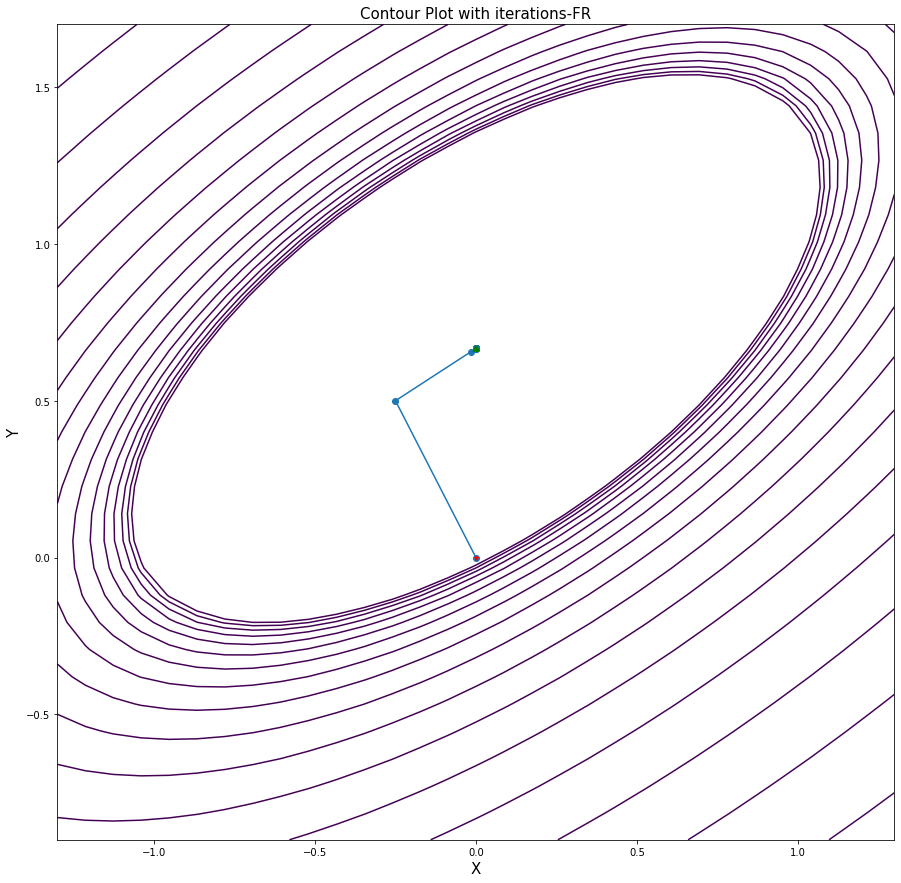

In [14]:
fig = plt.figure(figsize=(15, 15))
X, Y = np.meshgrid(np.linspace(-1.3, 1.3, 31), np.linspace(-0.9, 1.7, 31))
Z = obj_fun([X, Y])
plt.plot(np.array(fr['X']), np.array(fr['Y']), marker = 'o')
plt.plot([0], [0], 'x', mew=1, markersize=5, color='red', marker = '*')
plt.plot([0], [0.66667], 'y', mew = 2, markersize = 5, color = 'green', marker = '^')
plt.contour(X, Y, Z, np.logspace(-1, 3, 31))
plt.title("Contour Plot with iterations-FR", fontsize = 15)
plt.xlabel("X", fontsize = 15)
plt.ylabel("Y", fontsize = 15)
plt.show()

### Similarity between the directions from FR and DFP

In [12]:
ident_dir = (fr.Directions - DFP.Directions[0:3])[0:3]
for i in ident_dir:
    print(np.linalg.norm(i))

0.0
0.02428895201232323
0.09659190048878616


We observe that the norm of the difference is very small verifying that they are almost identical

## Contour Plot - DFP & FR

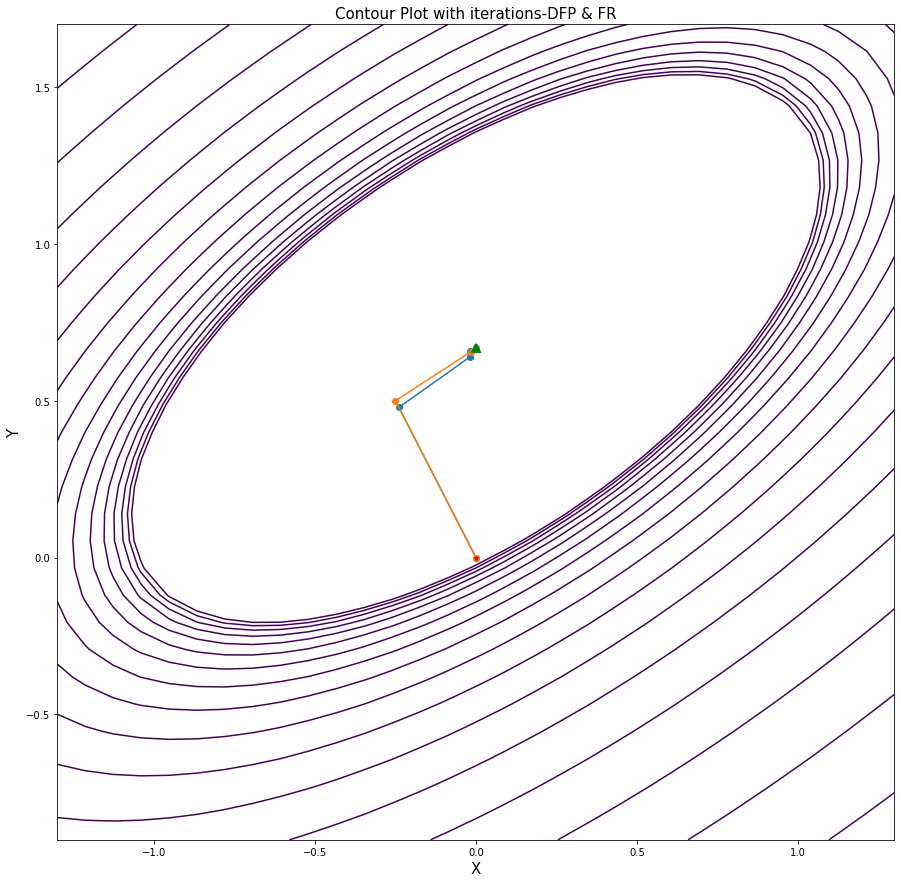

In [16]:
fig = plt.figure(figsize=(15, 15))
X, Y = np.meshgrid(np.linspace(-1.3, 1.3, 31), np.linspace(-0.9, 1.7, 31))
Z = obj_fun([X, Y])
plt.plot(np.array(DFP['Y1']), np.array(DFP['Y2']), marker = 'o')
plt.plot(np.array(fr['X']), np.array(fr['Y']), marker = 'o')
plt.plot([0], [0], 'x', mew=1, markersize=5, color='red', marker = '*')
plt.plot([0], [0.66667], 'y', mew = 2, markersize = 8, color = 'green', marker = '^')
plt.contour(X, Y, Z, np.logspace(-1, 3, 31))
plt.title("Contour Plot with iterations-DFP & FR", fontsize = 15)
plt.xlabel("X", fontsize = 15)
plt.ylabel("Y", fontsize = 15)
plt.show()

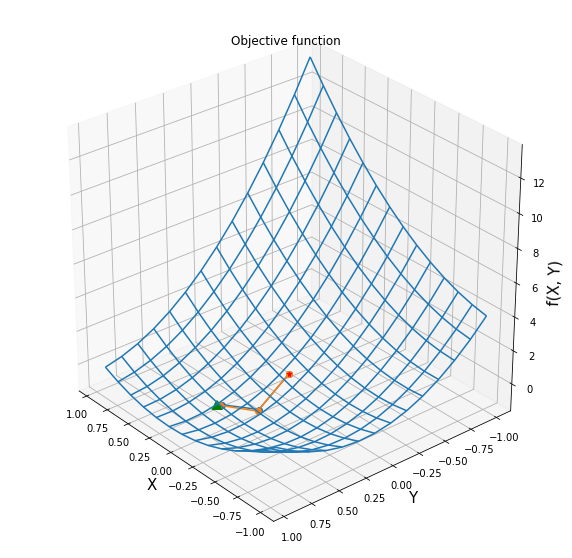

In [24]:
fig = plt.figure(figsize = (10, 10))
ax = fig.gca(projection = "3d")
X = np.arange(-1, 1, 0.15)
Y = np.arange(-1, 1, 0.15)
xmesh, ymesh = np.meshgrid(X, Y)
ax.plot_wireframe(xmesh, ymesh, obj_fun([xmesh, ymesh]))
plt.plot(np.array(DFP['Y1']), np.array(DFP['Y2']), marker = 'o')
plt.plot(np.array(fr['X']), np.array(fr['Y']), marker = 'o')
plt.plot([0], [0], 'x', mew=1, markersize=5, color='red', marker = '*')
plt.plot([0], [0.66667], 'y', mew = 2, markersize = 8, color = 'green', marker = '^')
ax.view_init(elev = 30, azim = 140)
plt.xlabel('X', fontsize = 15)
plt.ylabel('Y', fontsize = 15)
ax.set_zlabel('f(X, Y)', fontsize = 15)
plt.title("Objective function")
plt.show()